## table of contents
1. [libraries](#libraries)
2. [overall](#overall)
4. [model](#model)
5. [test](#test)

___
## libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mlframework

___
## overall

In [2]:
data = pd.read_csv('../02_feature_engineering/data.csv', index_col='sessionid')
data['dayname'] = data['dayname'].astype('category')
print(data.shape)
data.head()

(15000, 141)


,end,male,duration,dayname,weekend,worktime,nighttime,oclock,A00001,A00002,...,D07875,D10307,D13982,D14855,D18347,D18353,D22126,D33879,D35676,D35703
sessionid,,,,,,,,,,,,,,,,,,,,,
u10001,2014-11-14,0,6,Friday,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
u10002,2014-12-12,0,1,Friday,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
u10003,2014-11-14,0,839,Friday,0,0,1,1,0,12,...,0,0,0,0,0,0,0,0,0,0
u10004,2014-11-14,0,2,Friday,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
u10005,2014-11-14,0,197,Friday,0,0,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0


Data resulted from feature engineering, including (1) `end`, (2) label `male` and (3) time features and (4) product features.

___
## model

In [4]:
# Define column names in data
label_col = 'male'
label_time_col = 'end'
feat_cols = [col for col in data.columns if col not in [label_col, label_time_col]]

# Split data and tune lightgbm with optuna
shopping_ml = mlframework.MLFramework()
shopping_ml.train_valid_test_split(
    data=data,
    label_col=label_col,
    feat_cols=feat_cols,
    label_time_col=label_time_col,
    valid_size=0,  # not split for valid set yet. will be split in cross validation process
    test_size=7  # keep last 7 days for testing model (~25% total data)
)
shopping_ml.optuna_lgb(10)

[I 2022-01-09 22:05:34,636] A new study created in memory with name: no-name-7c29fe55-164a-4601-bcd3-4fa6284ad36d


Data and its partition (train, valid, test) are stored in attributes data, train, valid and test, respectively.


[I 2022-01-09 22:05:40,519] Trial 0 finished with value: 0.8586472454356595 and parameters: {'num_leaves': 62, 'max_depth': 7, 'min_data_in_leaf': 55, 'subsample': 0.7357952134817738, 'colsample_bytree': 0.5418757583662454, 'reg_alpha': 2.381817631690529e-08, 'reg_lambda': 0.0006287576372599632}. Best is trial 0 with value: 0.8586472454356595.
[I 2022-01-09 22:05:45,712] Trial 1 finished with value: 0.8472699598771548 and parameters: {'num_leaves': 291, 'max_depth': 6, 'min_data_in_leaf': 60, 'subsample': 0.40438911689559826, 'colsample_bytree': 0.4629500705655806, 'reg_alpha': 0.0006205979487241554, 'reg_lambda': 1.169682255357414e-07}. Best is trial 0 with value: 0.8586472454356595.
[I 2022-01-09 22:05:50,714] Trial 2 finished with value: 0.8837513746621688 and parameters: {'num_leaves': 591, 'max_depth': 4, 'min_data_in_leaf': 38, 'subsample': 0.33032965575907436, 'colsample_bytree': 0.9278340962155691, 'reg_alpha': 0.00011150954330238949, 'reg_lambda': 1.4739631158981374e-05}. Best

Best booster has been trained with num_boost_round=5.
New attributes assigned: study, best_params, cvbooster, booster.


In [5]:
feat_importance = shopping_ml.get_feature_importance(len(shopping_ml.train.data.columns))
(feat_importance > 0).value_counts()

False    118
True      21
Name: importance, dtype: int64

Only a part out of 139 features are used during the split (feature importance > 0). Since just a sub set of columns are selected at every split, these unuseful features may harm the performance of the split. Should remove them and re-train the model.

In [7]:
# Define column names in data
label_col = 'male'
label_time_col = 'end'
feat_cols = feat_importance.loc[lambda x: x > 0].index

# Split data and tune lightgbm with optuna
shopping_ml = mlframework.MLFramework()
shopping_ml.train_valid_test_split(
    data=data,
    label_col=label_col,
    feat_cols=feat_cols,
    label_time_col=label_time_col,
    valid_size=0,  # not split for valid set yet. will be split in cross validation process
    test_size=7  # keep last 7 days for testing model (~25% total data)
)
shopping_ml.optuna_lgb(10)

[I 2022-01-09 22:08:36,248] A new study created in memory with name: no-name-ed0c5f85-269d-4b2a-82e0-18f6a7c7b839


Data and its partition (train, valid, test) are stored in attributes data, train, valid and test, respectively.


[I 2022-01-09 22:08:42,937] Trial 0 finished with value: 0.8468037218370903 and parameters: {'num_leaves': 804, 'max_depth': 8, 'min_data_in_leaf': 13, 'subsample': 0.49268847332103805, 'colsample_bytree': 0.31118856101767495, 'reg_alpha': 0.009733672694332693, 'reg_lambda': 2.2742948272845382e-06}. Best is trial 0 with value: 0.8468037218370903.
[I 2022-01-09 22:08:48,442] Trial 1 finished with value: 0.8634009283022476 and parameters: {'num_leaves': 885, 'max_depth': 3, 'min_data_in_leaf': 98, 'subsample': 0.7470527113238687, 'colsample_bytree': 0.6090384756775395, 'reg_alpha': 0.0012486169877082974, 'reg_lambda': 1.3850756096108723e-07}. Best is trial 1 with value: 0.8634009283022476.
[I 2022-01-09 22:08:55,673] Trial 2 finished with value: 0.8510654971472666 and parameters: {'num_leaves': 489, 'max_depth': 10, 'min_data_in_leaf': 50, 'subsample': 0.6634888533373673, 'colsample_bytree': 0.866936281150495, 'reg_alpha': 1.056465834902906e-08, 'reg_lambda': 0.00010675957803724551}. Bes

Best booster has been trained with num_boost_round=4.
New attributes assigned: study, best_params, cvbooster, booster.


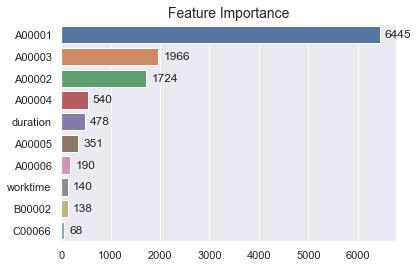

In [8]:
shopping_ml.plot_feature_importance()

`A00001`, `A00003` and `A00002` are the top features that contribute to best splits.

___
## test

In [9]:
pred_score = shopping_ml.predict(shopping_ml.test.data, cv=True)
pred_label = np.where(pred_score < 0.5, 0, 1)

accuracy = mlframework.accuracy_macro(pred_label, shopping_ml.test.label)
print(f'Macro-accuracy on test set is: {accuracy:.1%}')

Macro-accuracy on test set is: 81.0%


### bonus: gain table and calibrate curve

In [10]:
mlframework.get_gain_table(shopping_ml.test.label, pred_score)

,level,predict_min,predict_mean,predict_max,true_count,true_sum,true_mean
0,Level1,0.742801,0.849630,0.986668,371,284,0.765499
1,Level2,0.223434,0.485331,0.742069,370,187,0.505405
2,Level3,0.123869,0.154575,0.223174,370,52,0.140541
3,Level4,0.108531,0.113831,0.123836,359,53,0.147632
4,Level5,0.100873,0.105794,0.108477,381,46,0.120735
5,Level6,0.093210,0.096044,0.100807,353,41,0.116147
6,Level7,0.077075,0.087196,0.093186,388,32,0.082474
7,Level8,0.061206,0.069074,0.077020,370,41,0.110811
8,Level9,0.047289,0.054858,0.061150,370,36,0.097297
9,Level10,0.009294,0.033713,0.047285,371,38,0.102426


Two top levels are very well predicted with `true_mean` are 77% and 51%, respectively. Following levels are gradually less corrected. Especially, last three levels's `true_mean` are even higher than their previous level's.

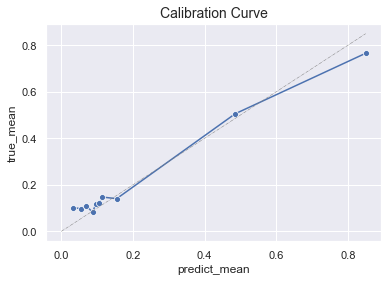

In [11]:
mlframework.plot_calibration_curve(shopping_ml.test.label, pred_score)

Visualization of the gain table.